<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-PotterSR/blob/main/Proyecto_Parcial/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm Project: Machine Learning 2023.

In [ ]:
!pip install corner
!pip install emcee
!pip install scienceplots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
plt.style.use(['science', 'no-latex'])
import emcee

We find spectral data from a star with only one absorption line.
That can be adjusted by this equation: \\
$y(x) = (A- Be^{-(x-x_o)^2 /2σ^2)})x^{-α}$

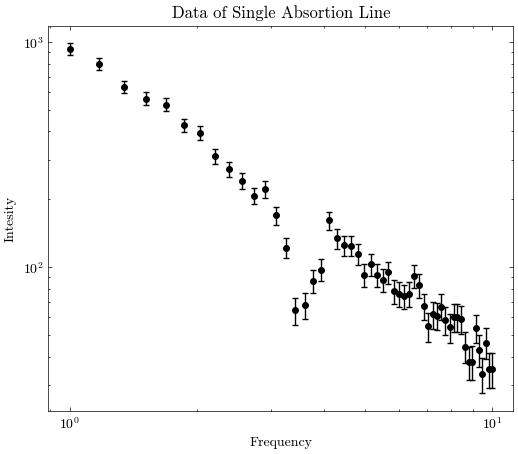

In [150]:
data = np.loadtxt('/content/drive/MyDrive/Data/dc-data_set.txt').T #Loading the data.

x, y, yerr = data
#Ploting the data
fig = plt.figure(figsize=(6,5))
plt.errorbar(x, y, yerr = yerr, marker='o', markersize=4,linestyle='none',mfc='black',mec='black',
			 capsize= 2, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Intesity', fontsize = 10)
plt.xlabel('Frequency', fontsize = 10)
plt.title('Data of Single Absortion Line')
plt.show()


We define all the functions needed for using the library emcee. That has implemented the algortim MCMC. We define our priors, likelihood, and our posterior.

$\ln(P) \alpha \ln(\mathscr{L}) + \ln(P_r)$ \\

$\ln(\mathscr{L}) \alpha -0.5(\sum_{i} (y_i - model(x_i; \vec{w})^{2})/(σ_{i}^{2}))$

We use a Flat Prior.

In [131]:

def model(parameters, x):
  #print(parameters)
  a, b, c, d, e = parameters

  return (a-b*np.exp(-(x-c)**2/(2*d**2)))*x**(-e)

def lnlike(x, y, yerr, theta, model=model):
  log = -1/2*np.sum((y- model(theta, x))**2/yerr**2 )
  return log

def lnprior(theta):
  a, b, c, d, e = theta

  if (700.0 < a < 1200.0) and (500.0 < b < 800.0) and (1.0 < c < 6.0) and (0.15 < d < 3.0) and (0.0 < e < 3.0):
    return 0
  return -np.inf

def lnprob(theta, x, y, yerr):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(x, y, yerr, theta)

We define our, initial points and all the configuration for the library MCMC.

In [132]:
np.random.seed(0)
# Configuración MCMC
nchains = 60
dims = 5
samples = 10000


coefs_iniciales=np.array([875.0, 600.0, 0.5, .3, 1.5])

initial_parameters = coefs_iniciales + 1e-1 * np.random.randn(nchains, dims)


sampler = emcee.EnsembleSampler(nchains, dims, lnprob, args=(x, y, yerr))


sampler.run_mcmc(initial_parameters, samples,progress=True);

100%|██████████| 10000/10000 [00:27<00:00, 365.47it/s]


We plot the result of the MCMC, given by emcee.

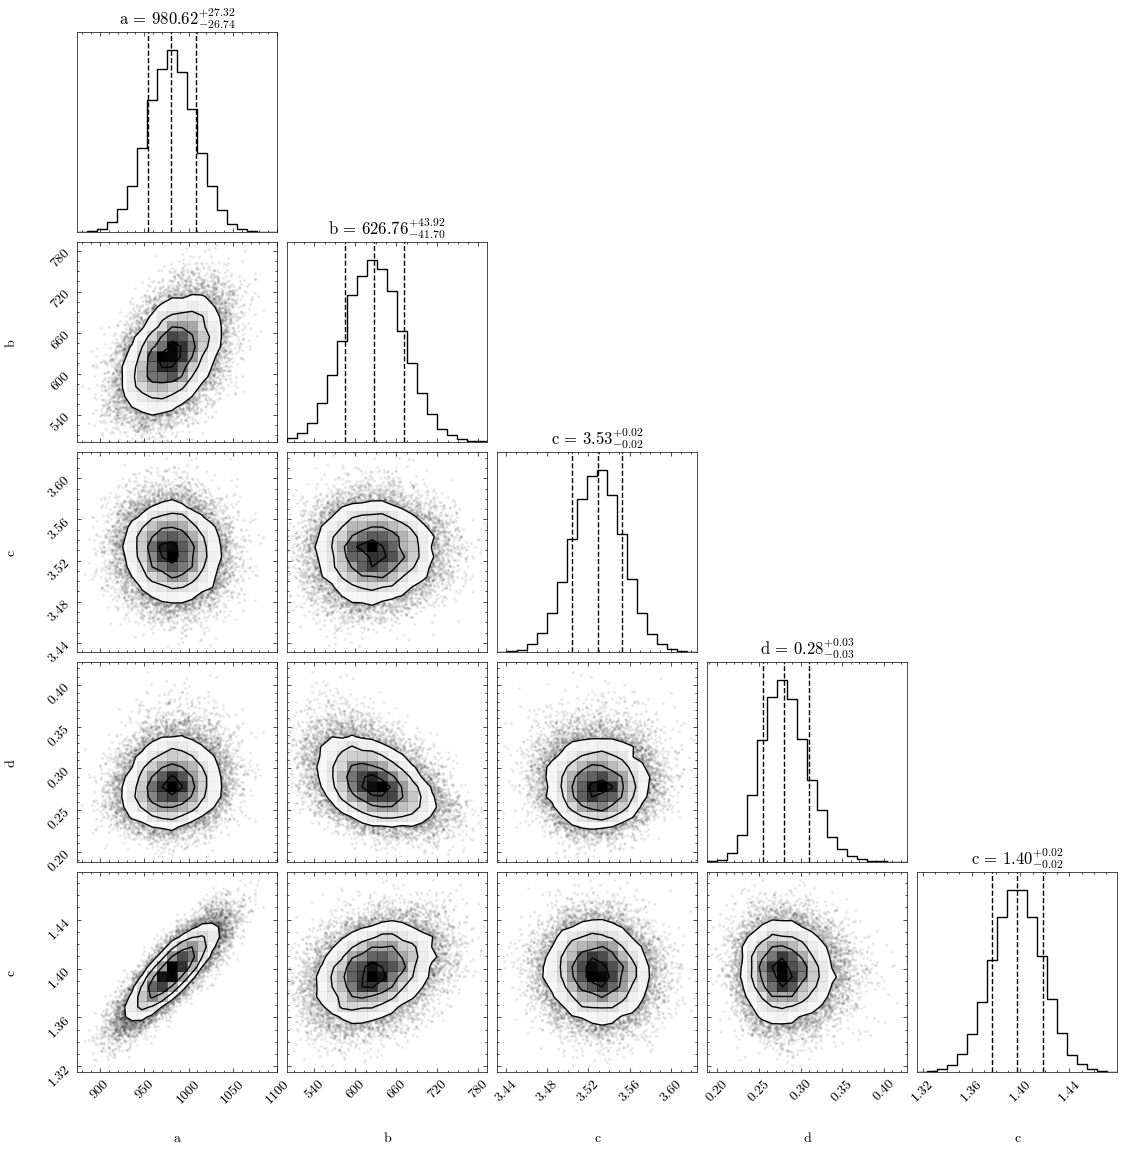

In [164]:
import corner

chains = sampler.get_chain(discard=3000, thin=20, flat=True) #We dont use the first 3000 points, and we get a sample every 20 points.

#Labels
labels = ["a", "b", "c", "d", "c"]

fig = corner.corner(chains, labels=labels, show_titles=True, fontsize =12, quantiles=[0.16, .5, .84]);

We make a plot of the chains in every step.

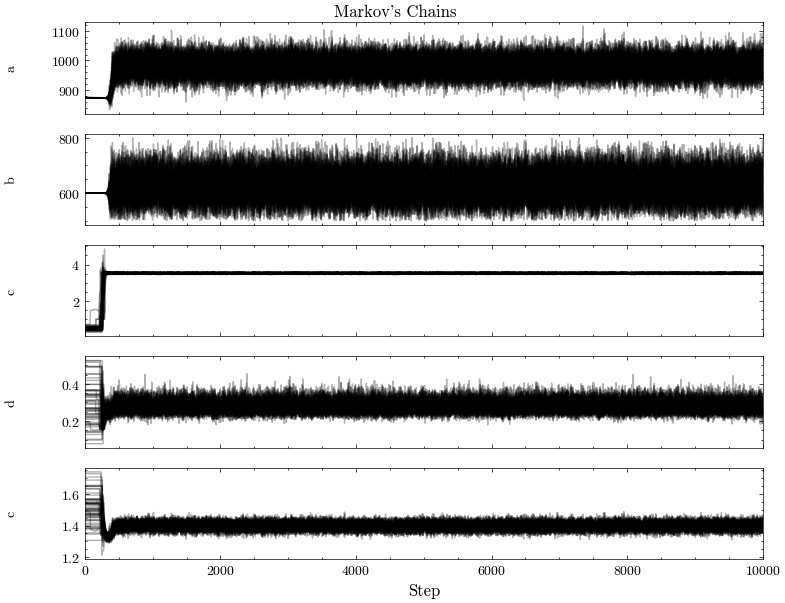

In [159]:
chains = sampler.get_chain()
fig, axes = plt.subplots(len(labels), figsize=(8, 6), sharex=True)
fig.suptitle("Markov's Chains")

for i in range(len(labels)):
    ax = axes[i]
    ax.plot(chains[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
axes[-1].set_xlabel('Step', fontsize = 12)
plt.show()

Then we plot the data with the results given by the MCMC.

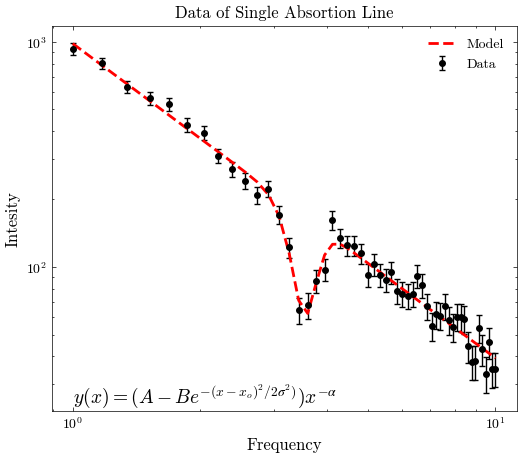

In [177]:
chains = sampler.get_chain(discard=3000, thin=20, flat=True)

weights = np.mean(chains, axis = 0)

fig = plt.figure(figsize=(6,5))
plt.errorbar(x, y, yerr = yerr, marker='o', markersize=4,linestyle='none',mfc='black',mec='black',
			 capsize= 2, color='black', label = 'Data')
plt.plot(x, model(weights, x), linestyle = '--', color = 'r', label = 'Model',
         linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel('Intesity', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)
plt.text(1, 25, r'$y(x) = (A- Be^{-(x-x_o)^2 /2σ^2)})x^{-α}$',
         fontsize = 14)
plt.title('Data of Single Absortion Line')
plt.show()


We tried to make our code, but didn't work. We think that the problem is how we generate the new chains and maybe the condition of acceptance.

In [136]:
def mc(x, y, yerr, n_iter, initial, sigmas):
    chain = [initial]
    theta_old = initial
    reject = []
    accept = []

    for _ in range(n_iter):
        #print(theta_old)
        theta_new = [theta_old[i] + np.random.normal(0, sigmas[i]) for i in range(5)]
        #print(theta_new)

        p_new = lnprob(theta_new, x, y, yerr)
        p_old = lnprob(theta_old, x, y, yerr)

        if p_new > p_old:
            chain.append(theta_new)
            accept.append(theta_new)
            theta_old = theta_new
        else:
            r = np.random.random()
            pn = p_new - p_old
            #print(pn, np.log(r)) # The Metropolis-Hastings ratio is the difference of log probabilities
            if pn > np.log(r):
                #print(pn, np.log(r))
                chain.append(theta_new)
                accept.append(theta_new)
                theta_old = theta_new
            else:
                chain.append(theta_old)
                reject.append(theta_new)

    chain = np.array(chain)
    print('Fraction Rejected:', len(reject) / len(chain), len(reject))
    print('Fraction Accepted:', len(accept) / len(chain), len(accept))
    return chain

In [145]:
x, y, yerr = data
n_iter = 1000000
initial_guess = [875.0, 600.0, 0.5, .3, 1.5]
sigmas = [15.0, 10.0, .1, .2, .2]

In [146]:
cad = mc(x, y, yerr, n_iter, initial_guess, sigmas)
cad = cad[10000:]

Fraction Rejected: 0.999999000001 1000000
Fraction Accepted: 0.0 0


Too few points to create valid contours


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


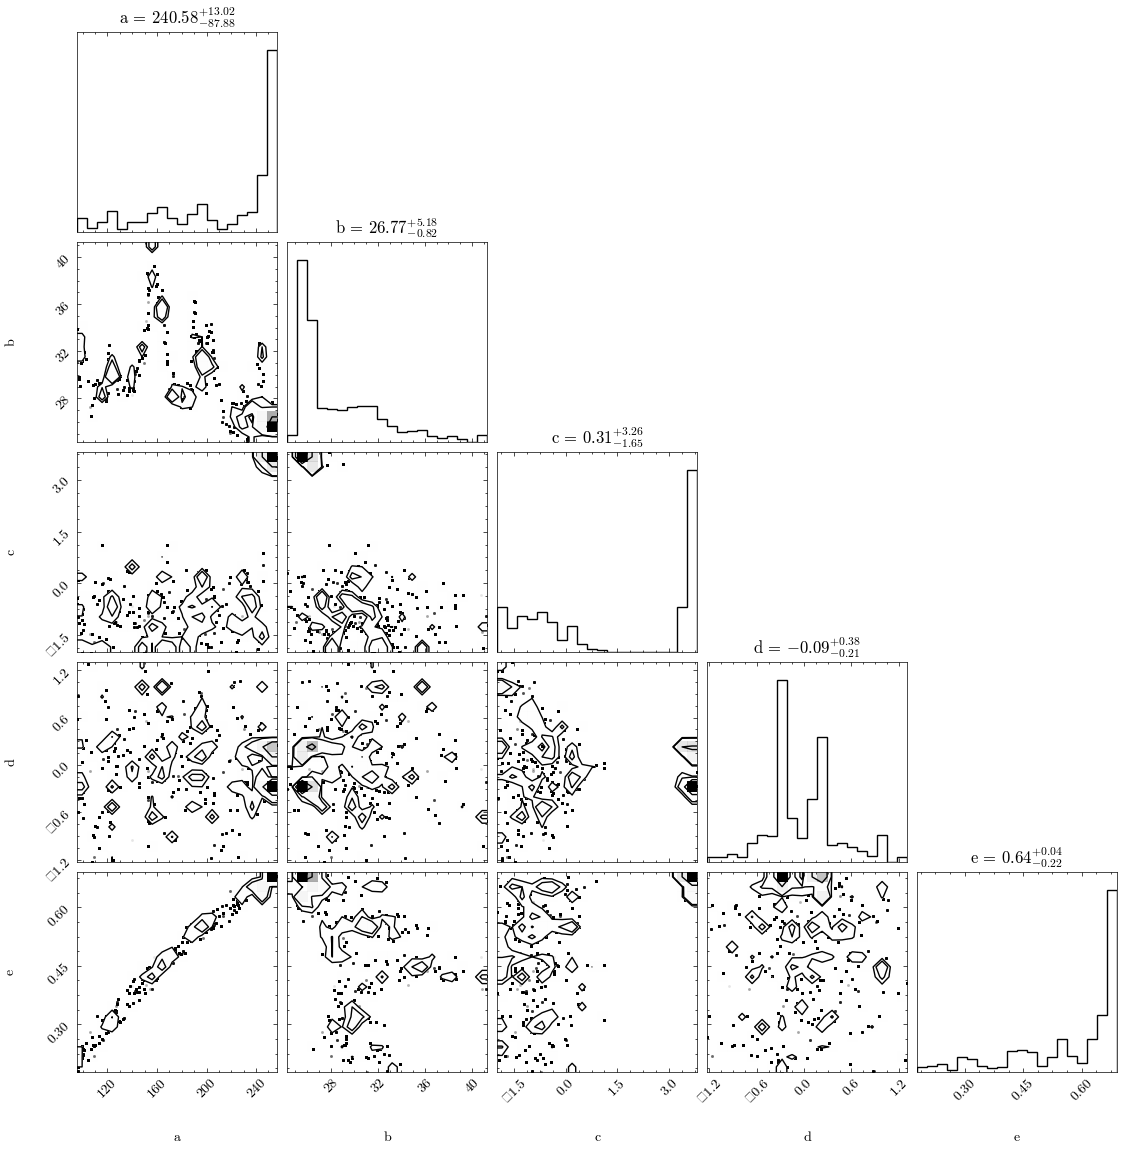

In [ ]:
corner.corner(cad, labels=["a", "b", "c", "d", "e"], show_titles=True)

plt.show()

#Tests

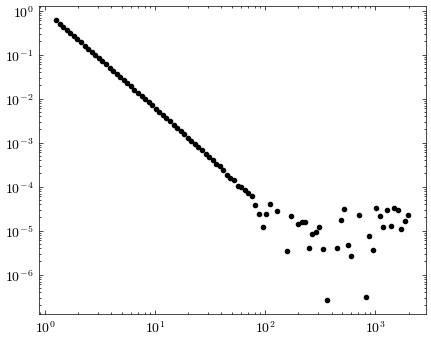

In [ ]:
def model_two(parameters, x):
  a, b, c, d = parameters
  y = (np.exp(-(x-1)/a)/(x**b)+c*np.exp(-(x-1)/d)/(x**(-b)))
  return y

np.random.seed(41)

real_params = [266,2.2, 1e-11, 1e3]

x_aux = np.logspace(.1,3.3, 100)
y = model_two(real_params, x_aux) + np.random.normal(0, 1e-5, size = 100)
yerr =  np.random.normal(0, 1e-2, size = 100)
f = plt.figure(figsize=(5,4))
plt.plot(x_aux, y, 'k', marker = '.', ls = 'none')
plt.yscale('log')
plt.xscale('log')

In [ ]:
def lnlike(x, y, theta, model=model_two):
  log = -1/2*np.sum((y- model(theta, x))**2/yerr**2+ np.log(yerr**2))
  return log

def lnprior(theta):
  a, b, c, d = theta

  if (100.0 < a < 300.0) and (1.0 < b < 3.0) and (-1 < c < 1) and (600.0 < d < 1200.0):
    return 0
  return -np.inf

def lnprob(theta, x, y):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(x, y, theta)

In [ ]:
nchains = 40 #Numero de cadenas
dims = 4     # Se van a estimar 4 parametros: w0,w1,w2 y w3
samples = 1500  # Número de pasos por cadena

#ya que 55 < w0 < 60 and -0.5 < w1 < 0 and 20 < w2 < 25
#intentaremos con el numero de enmedio, es decir:
#w0=57.5,w1=-0.25,w2=22.5
coefs_iniciales=np.array([150.0, 1.2, 0, 650.0])
#yerr=0.5 #error de la medicion

# Parámetros iniciales para las cadenas
initial_parameters = coefs_iniciales + 1e-5*np.random.randn(nchains, dims)

# Crear el objeto emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nchains, dims, lnprob, args=(x_aux, y))

# Ejecutar el MCMC
sampler.run_mcmc(initial_parameters, samples,progress=True);

100%|██████████| 1500/1500 [00:04<00:00, 310.00it/s]


In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)
samples.shape

(5600, 4)

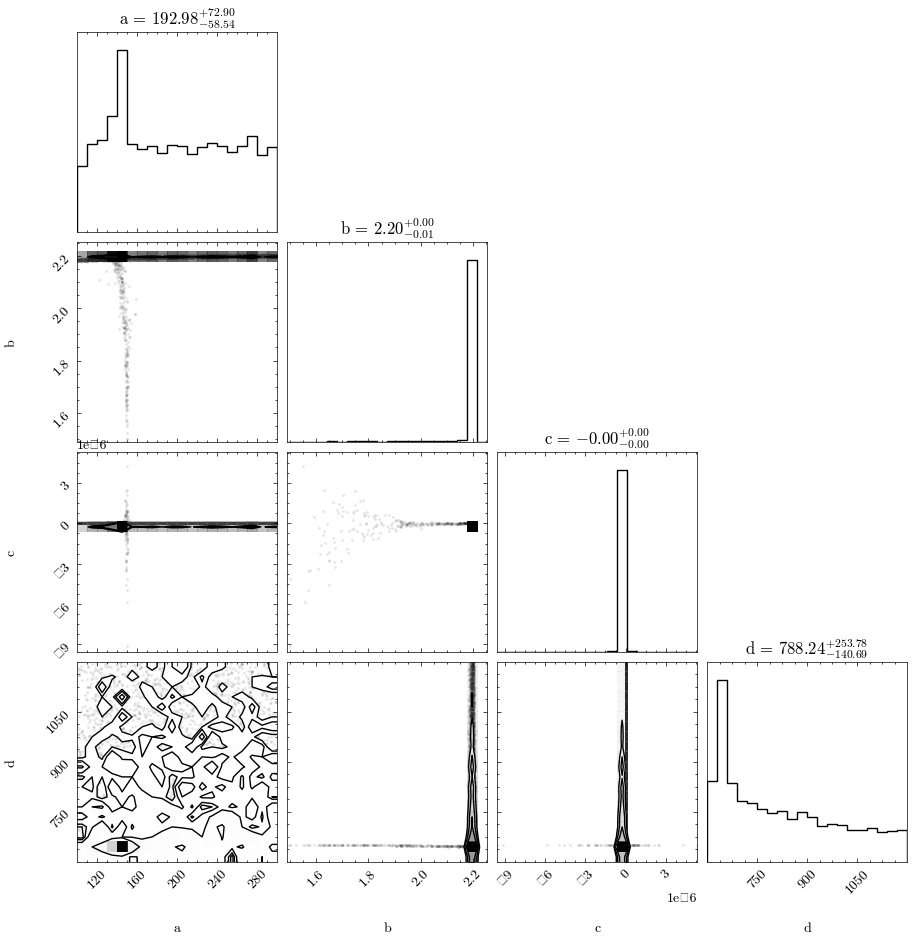

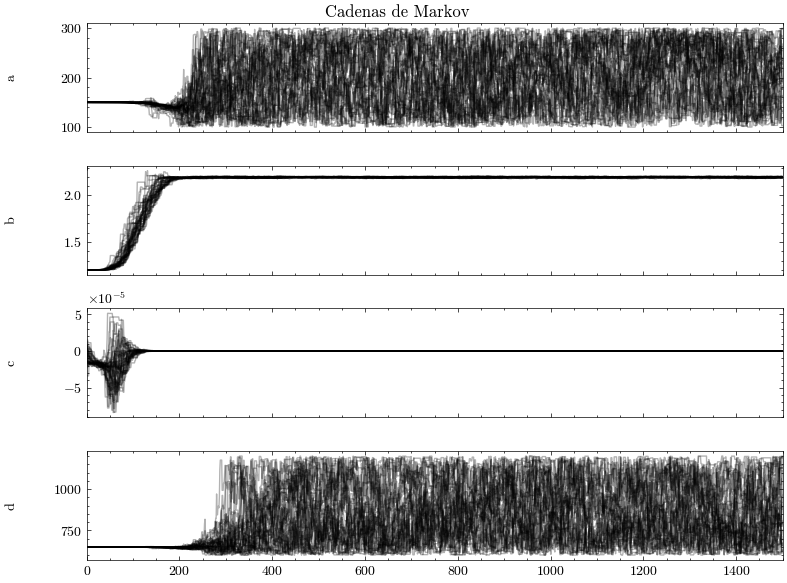

In [ ]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)
#cadena descartando 100 muestras, manteniendo una de cada 10 muestras y aplanando
param_names = ["a", "b", "c", "d"]

fig = corner.corner(samples, labels=param_names, show_titles=True)
#crear triangle plot con corner, son las graficas que parecen un camino

samples = sampler.get_chain()
#nuevamente cargo la cadena, PERO sin descartar ninguna muestra

# Configurar subtramas para cada parámetro
fig, axes = plt.subplots(len(param_names), figsize=(8, 6), sharex=True)
fig.suptitle("Cadenas de Markov")

# grafuci cada cadena, aqui es donde no descarto nada
for i in range(len(param_names)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:

from simplemc.cosmo.Parameter import Parameter
from simplemc.DriverMC import DriverMC

a = Parameter("a", 500, 0.05, (0, 1000.0), "A")
b = Parameter("b", 500, 0.05, (0, 1000.0), "B")
xo = Parameter("x", 2.5, 0.05, (-2.0, 5.0), "x_0")
sigma = Parameter("s", 2.5, 0.05, (-2,0, 5.0), "\sigma")
alpha = Parameter("al", 2.5, 0.05, (-2.0, 5.0), "\alpha")

# create a list with your parameters objects
parameterlist = [a, b, xo, sigma, alpha]

def model(parameters, x):
  a, b, c, d, e = parameterlist

  return (a-b*np.exp(-(x-c)**2/(2*d**2)))*x**(-e)

In [ ]:
my_model = '(a-b*np.exp(-(x-xo)**2/(2*sigma**2)))*x**(-alpha)'

analyzer = DriverMC(model='simple', datasets='generic', analyzername='mcmc',
                    custom_parameters=parameterlist, custom_function=my_model,
                    path_to_data='/content/drive/MyDrive/Data/dc-data_set.txt', fn='generic')

analyzer.executer(nsamp=1000)

Oscilador Subamortiguado. \\
$x(t) = ae^{-\gamma t}cos[ωt - α]$

In [ ]:
np.random.seed(45)

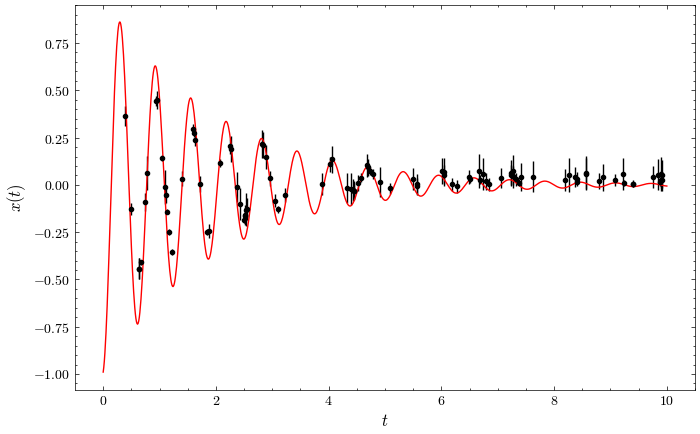

In [ ]:
def damped_oscilator(theta, t):
  a, b, c = theta
  y = np.exp(-a*t)*np.cos(b*t - c)
  return y

#True_Values
a_true = .5
b_true = 10
c_true = 3

real_values = [a_true, b_true, c_true]

t = np.sort(10 * np.random.rand(100))
yerr = 0.01 + .08*np.random.rand(100)
y = damped_oscilator(real_values, t)*np.random.rand() + yerr*np.random.rand()

f = plt.figure(figsize = (8, 5))
t0 = np.linspace(0, 10, 1000)
plt.errorbar(t, y, yerr = yerr, marker = '.',
             linestyle='none', color = 'k')
#plt.plot(t, damped_oscilator(real_values, t), '.', color = 'black')
plt.plot(t0, damped_oscilator(real_values, t0), '-', color = 'red')

plt.ylabel(r'$x(t)$', fontsize = 12)
plt.xlabel(r'$t$', fontsize = 12)
plt.show()